<a href="https://colab.research.google.com/github/GabrielAguilarFarrera/Metaheuristics/blob/main/NeurovisionDiffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diffusion-based Generative Modeling

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" align="left" src="https://licensebuttons.net/l/by-nc-sa/4.0/88x31.png" /></a>&nbsp; **JBH, VF, CM**

In [ ]:
%%capture
# This is to install a package from Huggingface that gives us access
# to a number of cool datasets, and another one that we will use for metrics
!pip install datasets
!pip install torchmetrics

We will describe a seminal work in the area of **diffusion-based generative modeling**.

* [Denoising Diffusion Probabilistic Models](https://arxiv.org/pdf/2006.11239.pdf). Jonathan Ho and Ajay Jain and Pieter Abbeel. 2020.

and then give an intuition about **two ideas that have made diffusion easier to use and more efficient**:

* [Denoising Difusion Implicit Models](https://arxiv.org/pdf/2010.02502.pdf). Jiaming Song, Chenlin Meng, Stefano Ermon. 2021.
* [High-Resolution Image Synthesis with Latent Diffusion Models](https://openaccess.thecvf.com/content/CVPR2022/papers/Rombach_High-Resolution_Image_Synthesis_With_Latent_Diffusion_Models_CVPR_2022_paper.pdf), Robin Rombach, Andreas Blattmann, Dominik Lorenz, Patrick Esser, Bjorn Ommer. 2021.


Diffusion models are one recent and succesful technique for **generative modelling**.

Suppose you are given a data point $
\mathbf{x}_0$ (a 2D image, an MRI image...) from a **target data distribution** $\pi$:

$$
\mathbf{x}_0 \sim \pi(\mathbf x).
$$

The goal of **generative modelling** is to learn to **produce samples that seem to come from $\pi$**, which is an implicit way of approximating $\pi(\mathbf x)$.

Example: learning to generate realistic SOMETHING with a model trained on SOMETHING.

Example in neuroimaging:
https://catalog.ngc.nvidia.com/models?filters=&orderBy=scoreDESC&query=label:%22Brain%22

Note that if one objective of generative modelling is to **generate samples** from some distribution of interest, it maybe also useful in **regression problems** where the expected predictive distributions are **highly multimodal**.

So, instead of a deterministic regression approach

$$
\hat{\mathbf x}=m_\theta(\mathbf i),
$$

use a stochastic one where you can explore different modes of your predictive distribution
$$
\mathbf x \sim m_\theta(\mathbf x;\mathbf i).
$$

Example in trajectory prediction:

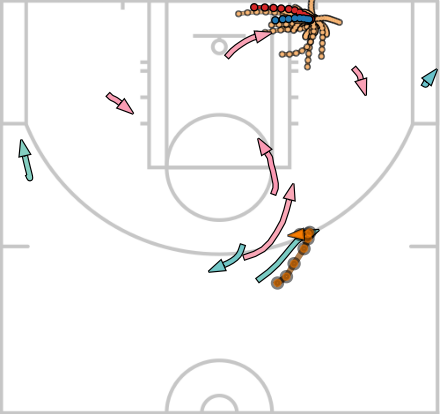

![Comparison of generative models](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/generative-overview.png)

Image from Lilian Weng's [blog](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/)

In [ ]:
import math, os, gc, time
from pathlib import Path
from dataclasses import dataclass
from IPython.display import display, HTML, clear_output

import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.cuda import amp
import torch.nn.functional as F
from torch.optim import Adam, AdamW
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as TF
import torchvision.datasets as datasets
from torchvision.utils import make_grid
from torchmetrics import MeanMetric


In [ ]:
BASE_DIR = Path(".").resolve()
BASE_DIR

PosixPath('/content')

In [ ]:
# Here is where we load the butterflies dataset
from datasets import load_dataset
dataset_name = "huggan/smithsonian_butterflies_subset"
dataset = load_dataset(dataset_name, split="train")

Repo card metadata block was not found. Setting CardData to empty.


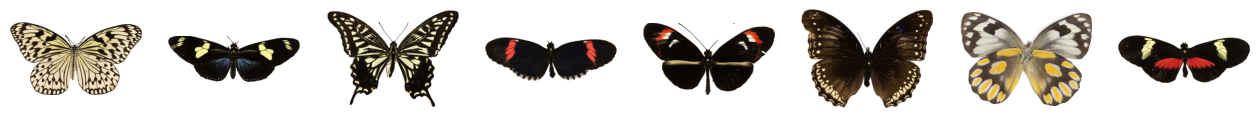

In [ ]:
# Display the first images from the dataset
ndisplay = 8
fig, axs = plt.subplots(1, ndisplay, figsize=(16, 8))
for i, image in enumerate(dataset[:ndisplay]["image"]):
    axs[i].imshow(image)
    axs[i].set_axis_off()
fig.show()

In [ ]:
# Check the image characteristics
print(dataset[0]["image"])

<PIL.PngImagePlugin.PngImageFile image mode=RGB size=512x283 at 0x793C9A52AA10>


In [ ]:
from torchvision import transforms
# We will resize our images to image_sizeximage_size
# The original are larger
image_size = 64
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size,image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        # The following is very important: it normalizes the color values
        # in the range [-1,1] (the original ones are within [0,1])
        transforms.Normalize([0.5], [0.5]),
    ]
)

In [ ]:
def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

def inverse_transform(tensors):
    """Convert tensors from [-1., 1.] to [0., 255.]"""
    return ((tensors.clamp(-1, 1) + 1.0) / 2.0) * 255.0

# Here we apply the different transformations defined above to
# the images of our dataset
dataset.set_transform(transform)

Number of batches:  63
torch.Size([4, 3, 64, 64])
tensor(-0.9686)
tensor(1.)


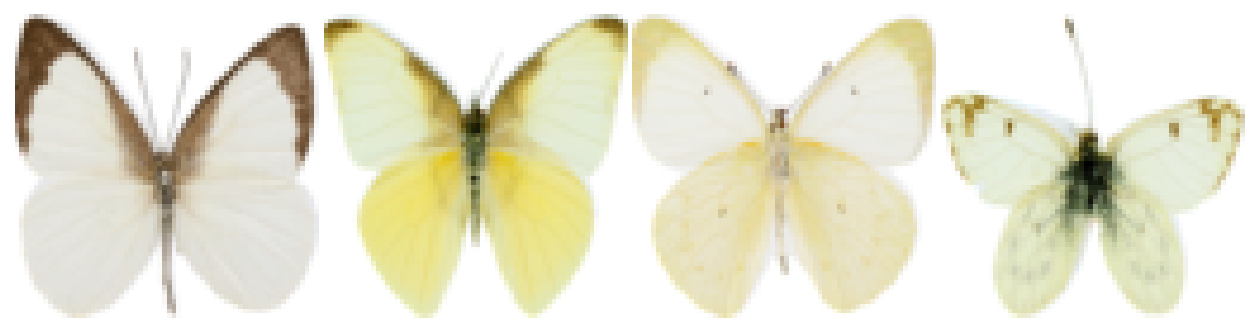

In [ ]:
import torch

train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)

print("Number of batches: ",len(train_dataloader))
plt.figure(figsize=(16, 8), facecolor='white')

# Take the first batch from the loader
for batch in train_dataloader:
    img = batch["images"]
    # Set as grid and show
    grid_img = make_grid(img[:4], nrow=4, padding=True, pad_value=1, normalize=True)
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis("off")
    # Sanity check: let us see the size, min/max values of the images after transformation
    print(img[:4].shape)
    print(img[:4].min())
    print(img[:4].max())
    break


In [ ]:
# Device to use later on
# It should be 'cuda'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


## Diffusion models

### Forward diffusion process

A **discrete-time forward diffusion process** applies a (controlled) Gaussian perturbation in $T$ steps $\mathbf x_1,...,\mathbf x_T$:

$$
q(\mathbf x_t|\mathbf x_{t-1})=\mathcal N(\sqrt{1-\beta_t}\mathbf x_{t-1},\beta_t \mathbf I),
$$

for a **fixed** (chosen beforehand) sequence $\beta_1, \dots \beta_T$ that satisfies:

$$
\beta_t\in[0,1]
$$

$$
\beta_1<\beta_2 \dots <\beta_T.
$$



A linearly spaced sequence is commonly used.

Note that:

$$
q(\mathbf x_{1:T}|\mathbf x_{0})=\prod_{t=1}^Tq(\mathbf x_t|\mathbf x_{t-1}).
$$

$\mathbf x_0$: noiseless data.

$\mathbf x_T$: noisy data, after $T$ diffusion steps

Let us define 2 intermediate variables $\alpha_t$ and $\bar{\alpha}_t$

$$
\alpha_t = 1-\beta_t
$$
$$
\bar{\alpha}_t = \prod_{i=1}^t \alpha_i.
$$

The reason we chose a Gaussian distribution for each diffusion step is that now the distribution $q(\mathbf x_t|\mathbf x_0)$ has an **analytical form**:

$$
q(\mathbf x_t|\mathbf x_{0})=\mathcal N(\sqrt{\bar{\alpha}_t}\mathbf x_0,(1-\bar{\alpha}_t)\mathbf I),
$$

So any sample at $t$, $\mathbf x_t$, can be seen either of the result of the sequential sampling described above or written more directly as:
$$
\mathbf x_t = \sqrt{\bar{\alpha}_t}\mathbf x_0 + \sqrt{1-\bar{\alpha}_t} \epsilon,
$$
with $\epsilon$ sampled from a normal distribution.

Also note that when $T$ is large enough, **the mean would tend to zero and the variance to $\mathbf I$**, i.e. we would tend to a **fixed distribution** of $\mathbf x_T$ (a **normal** distribution).

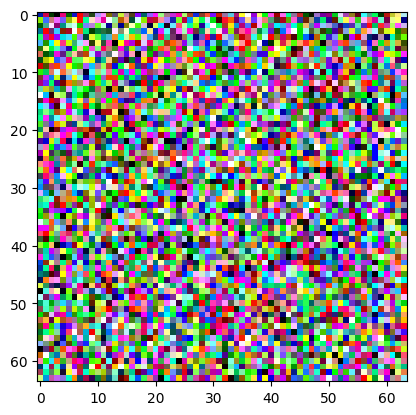

In [ ]:
# Let us see what xT will look like
x0      =  next(iter(train_dataloader))["images"][0]
xT      = 0.5+0.5*torch.randn_like(x0)
xT      = xT.clamp(0,1)
plt.imshow(xT.permute(1, 2, 0))


In [ ]:
def get_from_idx(element: torch.Tensor, idx: torch.Tensor):
    ele = element.gather(-1, idx)
    return ele.reshape(-1, 1, 1, 1)

# This class will be use for implementing the forward diffusion process
class ForwardSampler(nn.Module):
    def __init__(self, timesteps=1000, beta_start=1e-4, beta_end=2e-2):
        super().__init__()
        # Total number of steps in the diffusion process
        self.timesteps = timesteps
        # The betas and the alphas
        beta = torch.linspace(
                beta_start,
                beta_end,
                self.timesteps,
                dtype=torch.float32
            )
        self.register_buffer("beta", beta)
        # Some intermediate values that we will use
        self.register_buffer("alpha", 1 - self.beta)
        self.register_buffer("alpha_bar", torch.cumprod(self.alpha, dim=0))
        self.register_buffer("sqrt_alpha_bar", torch.sqrt(self.alpha_bar))
        self.register_buffer("one_by_sqrt_alpha", 1. / torch.sqrt(self.alpha))
        self.register_buffer("sqrt_one_minus_alpha_bar", torch.sqrt(1 - self.alpha_bar))

    # We use directly q(x_t|x_0) to generate one x_t given x_0.
    # This avoids to do all the individual diffusion steps.
    def forward(self, x0: torch.Tensor, timesteps: torch.Tensor):
        # Generate normal noise
        epsilon = torch.randn_like(x0)
        # Get the mean/standard deviation for the queried timesteps
        mean    = get_from_idx(self.sqrt_alpha_bar, timesteps) * x0      # Mean
        std_dev = get_from_idx(self.sqrt_one_minus_alpha_bar, timesteps) # Standard deviation
        # Sample is mean plus the scaled noise
        sample  = mean + std_dev * epsilon
        return sample, epsilon

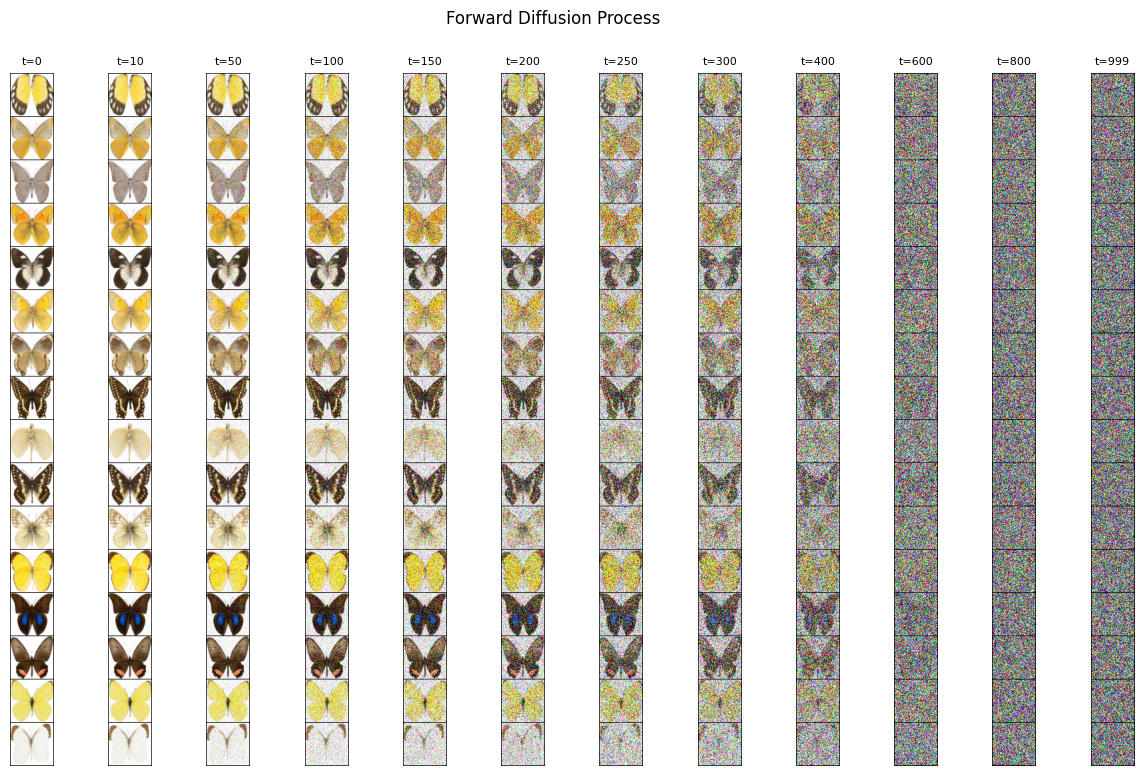

In [ ]:
# Take a batch of images
batch = next(iter(train_dataloader))

# Instantiate a forward sampler as above
fwdSampler = ForwardSampler(1000)

# Keeping the results for visualization
noisy_images = []

# Timesteps at which we will visualize the diffusion effect
specific_timesteps = [0, 10, 50, 100, 150, 200, 250, 300, 400, 600, 800, 999]

for timestep in specific_timesteps:
    timestep = torch.as_tensor(timestep, dtype=torch.long)
    x0s      = batch["images"]
    # Apply forward diffusion
    xts, _   = fwdSampler(x0s, timestep)
    # Rescale the images for visualization
    xts      = inverse_transform(xts).type(torch.uint8)
    xts      = make_grid(xts, nrow=1, padding=1)
    noisy_images.append(xts)

# Plot and see samples at different timesteps
_, ax = plt.subplots(1, len(noisy_images), figsize=(15, 9), facecolor='white')

# Display the results column by column
for i, (timestep, noisy_sample) in enumerate(zip(specific_timesteps, noisy_images)):
    ax[i].imshow(noisy_sample.squeeze(0).permute(1, 2, 0))
    ax[i].set_title(f"t={timestep}", fontsize=8)
    ax[i].axis("off")
    ax[i].grid(False)

plt.suptitle("Forward Diffusion Process", y=0.95)
plt.axis("off")
plt.show()


### Reverse process


To get a generative model, the idea would be to **reverse** this process. This would allow to start from $\mathbf x_T$ sampled from our fixed normal distribution and "come back" to the original data manifold, into a look-alike piece of data. What would be this reverse process?

$$
q(\mathbf x_{t-1}|\mathbf x_t).
$$

One problem is that a direct estimation of this "reverse" process is extremely difficult.

Idea is to use a **neural network** (with parameters $\theta$) to approximate these reverse conditional probabilities:

$$
p_\theta(\mathbf x_{t-1}|\mathbf x_t)
$$

as **Gaussian**, **time-dependent** probabilities:

$$
\mathcal N(\mathbf x_{t-1};\mu_\theta(\mathbf x_t,t),\Sigma_\theta(\mathbf x_t,t)).
$$

To help in training such a model, we first use the fact that, even if $q(\mathbf x_{t-1}|\mathbf x_{t})$ is hard,

$$
q(\mathbf x_{t-1}|\mathbf x_{t},\mathbf x_0)
$$

is much simpler to evaluate when you know $\mathbf x_0$ (as happens during **training**). In fact, we have, again, a **closed form**: By using the Bayes rule, we can show that it is a **Gaussian** with parameters

* $\tilde{\beta}_t = \frac{1-\bar{\alpha}_{t-1}}{1-\bar{\alpha}_{t}}\beta_t,$ (variance)
* $\tilde{\mu}_t(\mathbf x_t,\mathbf x_0) = \sqrt{\alpha_t}\frac{1-\bar{\alpha}_{t-1}}{1-\bar{\alpha}_{t}} \mathbf x_t + \frac{\beta_t\sqrt{\bar{\alpha}_{t-1}}}{1-\bar{\alpha}_{t}} \mathbf x_0,$ (mean).



Remember that we saw above that we could express $\mathbf x_t$ directly as a function of $\mathbf x_0$ (and **vice-versa**!):

$$
\mathbf x_t = \sqrt{\bar{\alpha}_t}\mathbf x_0 + \sqrt{1-\bar{\alpha}_t} \epsilon.
$$

Hence:

$$
\mathbf x_0 = \frac{1}{\sqrt{\bar{\alpha}_t}}(\mathbf x_t - \sqrt{1-\bar{\alpha}_t} \epsilon).
$$


As a consequence, we can rewrite the closed form of $q(\mathbf x_{t-1}|\mathbf x_{t},\mathbf x_0)$ as

* $\tilde{\beta}_t = \frac{1-\bar{\alpha}_{t-1}}{1-\bar{\alpha}_{t}}\beta_t$ (variance),
* $\tilde{\mu}_t(\mathbf x_t,\mathbf x_0) =  \frac{1}{\sqrt{\alpha_t}}(\mathbf x_t - \frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}_t}}  \epsilon)$ (mean),

which depends only on the current (noisy) sample $\mathbf x_t$ and on the "accumulated" noise vs. $\mathbf x_0$.



![Diffusion process](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/DDPM.png)

Image from Lilian Weng's [blog](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/)

### Training objective

As in most generative approaches, our goal is to train a model (here, $p_\theta$) such that the data from the training dataset ($\mathbf x_0$) have a **high likelihood under this distribution**:

$$
\theta^*= \arg\max_\theta \prod_{\mathbf x_0 \in \mathcal T} p_\theta(\mathbf x_0),
$$

or equivalently to have a **low value** of the minus log likelihood

$$
\theta^*= \arg\min_\theta -\sum_{\mathbf x_0 \in \mathcal T} \log p_\theta(\mathbf x_0).
$$


Now, in the same way as with VAE models, we can exhibit an **upper bound** to this negative log-likelihood (the famous **ELBO**) as:

$$
E_{q(\mathbf x_0)}[-\log p_\theta(\mathbf x_0)] \leq E_{q(\mathbf x_{0:T})}[\log\frac{q(\mathbf x_{1:T}|\mathbf x_0)}{p_\theta(\mathbf x_{0:T})}].
$$

Check the paper for the detailed proof. Now we are nearly done because if we minimize the ELBO, we will be also (**indirectly**) **maximizing the data likelihood**, and the expression on the right should be tractable into known ingredients that we have seen before. Note that is is expressed a an **expected value over trajectories**.

The authors show that the loss above:

$$
\mathcal L(\theta) \triangleq E_{q(\mathbf x_{0:T})}[\log\frac{q(\mathbf x_{1:T}|\mathbf x_0)}{p_\theta(\mathbf x_{0:T})}]
$$

can be rewritten as the sum of three terms:

$$
\mathcal L(\theta) = E_{q(\mathbf x_{0:T})}[D_{KL}(q(\mathbf x_T|\mathbf x_0),p_\theta(\mathbf x_T)) + \sum_{t=2}^T D_{KL}(q(\mathbf x_{t-1}|\mathbf x_t,\mathbf x_0),p_\theta(\mathbf x_{t-1}|\mathbf x_t)) - \log p_\theta(\mathbf x_0|\mathbf x_1)]
$$

Observations:

* $p_\theta(\mathbf x_T)$, as we saw, is in fact a constant (normal distribution) for $T$ large enough; hence the first term is **constant** and does not need to be optimized;
* We saw that both $q(\mathbf x_{t-1}|\mathbf x_t,\mathbf x_0)$ and $p_\theta(\mathbf x_{t-1}|\mathbf x_t)$ are **Gaussian distributions** and we are trying to match them. The KL divergence has a **closed form** in that case.

### Re-parameterization and simplification

A design choice by the authors is to set the variance matrix as:

$$
\Sigma_\theta(\mathbf x_t,t) \triangleq \sigma^2_t \mathbf I.
$$

They report having tried for example $\sigma^2_t=\beta_t$ and having obtained good results.

After this choice, the loss simplifies a lot since the individual divergences $\mathcal L_t$ can be re-written as:

$$
\mathcal L_t \triangleq D_{KL}(q(\mathbf x_{t-1}|\mathbf x_t,\mathbf x_0),p_\theta(\mathbf x_{t-1}|\mathbf x_t))= E_{\mathbf x_0,\epsilon}[\frac{1}{2\sigma^2_t}\|\tilde{\mu}_t(\mathbf x_t,\mathbf x_0)-\tilde{\mu}_\theta(\mathbf x_t,t)\|^2]
$$

with $\tilde{\mu}_t(\mathbf x_t,\mathbf x_0) =  \frac{1}{\sqrt{\alpha_t}}(\mathbf x_t - \frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}_t}}  \epsilon)$.


Hence, the authors suggest to re-parameterize:

$\tilde{\mu}_\theta(\mathbf x_t,t) \triangleq  \frac{1}{\sqrt{\alpha_t}}(\mathbf x_t - \frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}_t}}  \epsilon_\theta(\mathbf x_t,t))$

i.e., to try to **predict the noise** $\epsilon$.

In [ ]:
# This is a class that derives from ForwardSampler
# and that will add the posibility to do one step backwards
class DDPM(ForwardSampler):
    # This will implement one step back in the reverse process
    def step_backward(self, predicted_noise:torch.Tensor, xnoise:torch.Tensor, timestep: int):
        # Noise from normal distribution
        z  = torch.randn_like(xnoise) if timestep > 0 else torch.zeros_like(xnoise)
        beta_t                     = self.beta[timestep].reshape(-1, 1, 1, 1)
        one_by_sqrt_alpha_t        = self.one_by_sqrt_alpha[timestep].reshape(-1, 1, 1, 1)
        sqrt_one_minus_alpha_bar_t = self.sqrt_one_minus_alpha_bar[timestep].reshape(-1, 1, 1, 1)
        # Use the formula above to sample a denoised version from the noisy one
        xdenoised = (
            one_by_sqrt_alpha_t
            * (xnoise - (beta_t / sqrt_one_minus_alpha_bar_t) * predicted_noise)
            + torch.sqrt(beta_t) * z
        )
        return xdenoised

By rewriting the loss $\mathcal L_t$ with this reparameterization, after some developments, we get

\begin{align}
\mathcal L_t &=& E_{\mathbf x_0,\epsilon_t}[\frac{1}{2\sigma^2_t}\frac{(1-\alpha_t)^2}{\alpha_t(1-\bar{\alpha}_t)}\|\epsilon_\theta(\sqrt{\bar{\alpha}_t}\mathbf x_0+\sqrt{1-\bar{\alpha}_t}\epsilon_t,t)-\epsilon_t\|^2].
\end{align}


The authors even propose to simplify this loss by not taking into account the factor:

\begin{align}
\tilde{\mathcal L}_t &=& E_{\mathbf x_0,\epsilon_t}[\|\epsilon_\theta(\sqrt{\bar{\alpha}_t}\mathbf x_0+\sqrt{1-\bar{\alpha}_t}\epsilon_t,t)-\epsilon_t\|^2].
\end{align}

Think a bit on what this $\epsilon_\theta$ does: it will be a model (e.g. a neural network) that would take the noisy image $\mathbf x_t$, the time step $t$.  

![Diffusion process](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/DDPM-algo.png)

Image from Lilian Weng's [blog](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/)

In [ ]:
def train_step(batch:torch.Tensor, model:nn.Module, forwardsampler:DDPM):
    # Sample a timestep uniformly
    t = torch.randint(low=0, high=forwardsampler.timesteps, size=(batch.shape[0],), device=batch.device)
    # Apply forward noising process on original images, up to step t (sample from q(x_t|x_0))
    x_noisy, eps_true = forwardsampler(batch, t)
    with amp.autocast():
        # Our prediction for the denoised image
        eps_predicted = model(x_noisy, t)
        # Deduce the loss
        loss          = F.mse_loss(eps_predicted, eps_true)
    return loss

In [ ]:
# This is how we will use the model once trained
@torch.inference_mode()
def generate(denoiser_model:nn.Module, backward_sampler:DDPM, size, device):
    # Noise from a normal distribution
    x_T = torch.randn(size, device=device)
    # Now, to reverse the diffusion process, use a sequence of denoising steps
    # for t in reversed(range(backward_sampler.timesteps)):
    for t in tqdm(iterable=reversed(range(0, backward_sampler.timesteps)),
                          dynamic_ncols=False,total=backward_sampler.timesteps,
                          desc="Sampling :: ", position=0):
        t_tensor = torch.as_tensor(t, dtype=torch.long, device=device).reshape(-1).expand(xnoisy.shape[0])
        # Estimate the noise
        eps_pred = denoiser_model(x_T, t_tensor)
        # Denoise with the sampler and the estimation of the noise
        x_T= backward_sampler.step_backward(eps_pred, x_T, t)
    return x_T

Finally: an important technical question is how to implement $\epsilon_\theta(\mathbf x_t,t)$!

* In this case, we want a NN that takes images as input and produces images of the same size: **U-Net**.
* The dependency to time is critical!

Following implementation is nearly:
https://github.com/spmallick/learnopencv/blob/master/Guide-to-training-DDPMs-from-Scratch/Generating_MNIST_using_DDPMs.ipynb

## Training The Model

### The UNet model

This is the model that we will use for:

$$
\epsilon_\theta(\mathbf x_t,t).
$$

* Takes an image and the timestep.
* Outputs an image of the same size that estimates the noise.

![Unet](https://miro.medium.com/v2/resize:fit:720/format:webp/1*f7YOaE4TWubwaFF7Z1fzNw.png)


We then need a way to encode time into the model. We will borrow *Transformer*'s Fourier-like embeddings.

These embeddings will be first adjusted to propery size and then added to the tensor **at each level of the UNet**.

In [ ]:
# Positional embedding (for including time information)
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, total_time_steps=1000, time_emb_dims=128, time_emb_dims_exp=512):
        super().__init__()

        half_dim = time_emb_dims // 2

        emb = math.log(10000) / (half_dim - 1)
        # Frequencies
        emb = torch.exp(torch.arange(half_dim, dtype=torch.float32) * -emb)
        # Time steps
        ts  = torch.arange(total_time_steps, dtype=torch.float32)
        # Form the angles as products time steps * frequencies
        emb = torch.unsqueeze(ts, dim=-1) * torch.unsqueeze(emb, dim=0)
        # Half for sines, alf for cosines
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)

        self.time_blocks = nn.Sequential(
            # The positional encodings are in emb
            nn.Embedding.from_pretrained(emb),
            # Linear layer
            nn.Linear(in_features=time_emb_dims, out_features=time_emb_dims_exp),
            # Activation
            nn.SiLU(),
            # Linear layer
            nn.Linear(in_features=time_emb_dims_exp, out_features=time_emb_dims_exp),
        )

    def forward(self, time):
        return self.time_blocks(time)

In [ ]:
# Attention block
class AttentionBlock(nn.Module):
    def __init__(self, channels=64):
        super().__init__()
        self.channels  = channels
        self.group_norm= nn.GroupNorm(num_groups=8,num_channels=channels)
        self.mhsa      = nn.MultiheadAttention(embed_dim=self.channels,num_heads=4,batch_first=True)

    def forward(self, x):
        B, _, H, W = x.shape
        h          = self.group_norm(x)
        h          = h.reshape(B, self.channels, H * W).swapaxes(1, 2)  # [B, C, H, W] --> [B, C, H * W] --> [B, H*W, C]
        h, _       = self.mhsa(h, h, h)  # [B, H*W, C]
        h          = h.swapaxes(2, 1).view(B, self.channels, H, W)  # [B, C, H*W] --> [B, C, H, W]
        return x + h



In [ ]:
#@title [Code] If you want to see it, just click

# Resnet block
class ResnetBlock(nn.Module):
    def __init__(self, *, in_channels, out_channels, dropout_rate=0.1, time_emb_dims=512, apply_attention=False):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels= out_channels

        self.activation  = nn.SiLU()
        # Group 1
        self.normalize_1 = nn.GroupNorm(num_groups=8, num_channels=self.in_channels)
        self.conv_1      = nn.Conv2d(in_channels=self.in_channels, out_channels=self.out_channels, kernel_size=3, stride=1, padding="same")

        # Group 2 time embedding
        self.dense_1    = nn.Linear(in_features=time_emb_dims, out_features=self.out_channels)

        # Group 3
        self.normalize_2= nn.GroupNorm(num_groups=8, num_channels=self.out_channels)
        self.dropout    = nn.Dropout2d(p=dropout_rate)
        self.conv_2     = nn.Conv2d(in_channels=self.out_channels, out_channels=self.out_channels, kernel_size=3, stride=1, padding="same")

        if self.in_channels != self.out_channels:
            self.match_input = nn.Conv2d(in_channels=self.in_channels, out_channels=self.out_channels, kernel_size=1, stride=1)
        else:
            self.match_input = nn.Identity()

        if apply_attention:
            self.attention = AttentionBlock(channels=self.out_channels)
        else:
            self.attention = nn.Identity()

    def forward(self, x, t):
        # Group 1
        h = self.activation(self.normalize_1(x))
        h = self.conv_1(h)

        # Group 2
        # add in timestep embedding
        h += self.dense_1(self.activation(t))[:, :, None, None]

        # Group 3
        h = self.activation(self.normalize_2(h))
        h = self.dropout(h)
        h = self.conv_2(h)

        # Residual and attention
        h = h + self.match_input(x)
        h = self.attention(h)

        return h



In [ ]:
#@title [Code] If you want to see it, just click

# Downsampling-convolutive layer
class DownSample(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.downsample = nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=3, stride=2, padding=1)
    def forward(self, x, *args):
        return self.downsample(x)

# Upsampling-convolutive layer
class UpSample(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.upsample = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="nearest"),
            nn.Conv2d(in_channels=in_channels, out_channels=in_channels, kernel_size=3, stride=1, padding=1))
    def forward(self, x, *args):
        return self.upsample(x)



In [ ]:
#@title [Code] If you want to see it, just click

# The UNet
class UNet(nn.Module):
    def __init__(
        self,
        input_channels = 3,
        output_channels= 3,
        num_res_blocks = 2,
        base_channels  = 128,
        # Resolutions
        base_channels_multiples=(1, 2, 4, 8),
        # Attention, per resolution level
        apply_attention=(False, False, True, False),
        dropout_rate   = 0.1,
        time_multiple  = 4,
    ):
        super().__init__()

        time_emb_dims_exp    = base_channels * time_multiple
        self.time_embeddings = SinusoidalPositionEmbeddings(time_emb_dims=base_channels, time_emb_dims_exp=time_emb_dims_exp)

        self.first = nn.Conv2d(in_channels=input_channels, out_channels=base_channels, kernel_size=3, stride=1, padding="same")

        num_resolutions = len(base_channels_multiples)

        # Encoder part of the UNet. Dimension reduction.
        self.encoder_blocks = nn.ModuleList()
        curr_channels       = [base_channels]
        in_channels         = base_channels

        # For each resolution level
        for level in range(num_resolutions):
            # Number of output channels for this level
            out_channels = base_channels * base_channels_multiples[level]

            # For each residual block
            for _ in range(num_res_blocks):
                # Create block
                block = ResnetBlock(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    dropout_rate=dropout_rate,
                    time_emb_dims=time_emb_dims_exp,
                    apply_attention=apply_attention[level],
                )
                # Add it to the group of blocks
                self.encoder_blocks.append(block)

                in_channels = out_channels
                curr_channels.append(in_channels)

            # For all the levels before the last, add a DownSample
            if level != (num_resolutions - 1):
                self.encoder_blocks.append(DownSample(channels=in_channels))
                curr_channels.append(in_channels)

        # Bottleneck between the encoder and decoder
        self.bottleneck_blocks = nn.ModuleList(
            (
                ResnetBlock(
                    in_channels=in_channels,
                    out_channels=in_channels,
                    dropout_rate=dropout_rate,
                    time_emb_dims=time_emb_dims_exp,
                    apply_attention=True,
                ),
                ResnetBlock(
                    in_channels=in_channels,
                    out_channels=in_channels,
                    dropout_rate=dropout_rate,
                    time_emb_dims=time_emb_dims_exp,
                    apply_attention=False,
                ),
            )
        )

        # Decoder part of the UNet. Dimension restoration with skip-connections.
        self.decoder_blocks = nn.ModuleList()

        # Decoder
        for level in reversed(range(num_resolutions)):
            out_channels = base_channels * base_channels_multiples[level]

            for _ in range(num_res_blocks + 1):
                encoder_in_channels = curr_channels.pop()
                block = ResnetBlock(
                    in_channels=encoder_in_channels + in_channels,
                    out_channels=out_channels,
                    dropout_rate=dropout_rate,
                    time_emb_dims=time_emb_dims_exp,
                    apply_attention=apply_attention[level],
                )

                in_channels = out_channels
                self.decoder_blocks.append(block)

            if level != 0:
                self.decoder_blocks.append(UpSample(in_channels))

        # A last convolutional block
        self.final = nn.Sequential(
            nn.GroupNorm(num_groups=8, num_channels=in_channels),
            nn.SiLU(),
            nn.Conv2d(in_channels=in_channels, out_channels=output_channels, kernel_size=3, stride=1, padding="same"),
        )

    def forward(self, x, t):
        # Time embeddings
        time_emb = self.time_embeddings(t)

        h    = self.first(x)
        outs = [h]

        # Encoder
        for layer in self.encoder_blocks:
            h = layer(h, time_emb)
            outs.append(h)

        # Bottleneck
        for layer in self.bottleneck_blocks:
            h = layer(h, time_emb)

        # Decoder
        for layer in self.decoder_blocks:
            if isinstance(layer, ResnetBlock):
                out = outs.pop()
                h = torch.cat([h, out], dim=1)
            h = layer(h, time_emb)

        h = self.final(h)

        return h

In [ ]:
# Hyperparameters
@dataclass
class ModelConfig:
    BASE_CH = 64  # 64, 128, 256, 512
    BASE_CH_MULT = (1, 2, 4, 8) # 32, 16, 8, 4
    APPLY_ATTENTION = (False, True, True, False)
    DROPOUT_RATE = 0.1
    TIME_EMB_MULT = 4 # 128
    SAVE_DIR = BASE_DIR/"models"
    MODEL_NAME = "UNet_Butterflies_{}.pth"

@dataclass
class TrainingConfig:
    TIMESTEPS  = 1000 # Define number of diffusion timesteps
    IMG_SHAPE  = (3, image_size, image_size)
    NUM_EPOCHS = 10
    LR         = 1e-4
    NUM_WORKERS= 2
    LOG_EACH   = 20
ModelConfig.SAVE_DIR.mkdir(exist_ok=True)

In [ ]:
# Instanciate the UNet for the reverse diffusion
denoiser_model = UNet(
    input_channels          = TrainingConfig.IMG_SHAPE[0],
    output_channels         = TrainingConfig.IMG_SHAPE[0],
    base_channels           = ModelConfig.BASE_CH,
    base_channels_multiples = ModelConfig.BASE_CH_MULT,
    apply_attention         = ModelConfig.APPLY_ATTENTION,
    dropout_rate            = ModelConfig.DROPOUT_RATE,
    time_multiple           = ModelConfig.TIME_EMB_MULT,
)
denoiser_model.to(DEVICE)

# The optimizer (weight decay Adam)
optimizer = torch.optim.AdamW(denoiser_model.parameters(), lr=TrainingConfig.LR)

# Loss
loss_fn = nn.MSELoss()

# Instantiate the diffusion model
diffusionmodel = DDPM(timesteps = TrainingConfig.TIMESTEPS)
diffusionmodel.to(DEVICE)
scaler = amp.GradScaler()


In [ ]:
def num_params(module:nn.Module):
    n = 0
    for m in module.parameters():
        if m.requires_grad:
            n += m.numel()
    return n
num_params(denoiser_model)

58224515

In [ ]:
# Training: one epoch
def train_one_epoch(model, sampler, loader, optimizer, scaler, loss_fn, epoch=800):

    loss_record = MeanMetric()
    # Set in training mode
    model.train()

    with tqdm(total=len(loader), dynamic_ncols=True) as tq:
        tq.set_description(f"Train :: Epoch: {epoch}/{TrainingConfig.NUM_EPOCHS}")
        # Scan the batches
        for batch in loader:
            tq.update(1)
            imgs = batch["images"].to(DEVICE)

            # Evaluate loss
            loss = train_step(imgs, model, sampler)

            # Backpropagation and update
            optimizer.zero_grad(set_to_none=True)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            loss_value = loss.detach().item()
            loss_record.update(loss_value)

            tq.set_postfix_str(s=f"Loss: {loss_value:.4f}")

        mean_loss = loss_record.compute().item()

        tq.set_postfix_str(s=f"Epoch Loss: {mean_loss:.4f}")

    return mean_loss

In [ ]:
# Training loop
for epoch in range(1, TrainingConfig.NUM_EPOCHS + 1):
    torch.cuda.empty_cache()
    gc.collect()

    # Training step
    train_one_epoch(denoiser_model, diffusionmodel, train_dataloader, optimizer, scaler, loss_fn, epoch=epoch)

    # Every LOG_EACH epochs, check how it goes
    if epoch % TrainingConfig.LOG_EACH == 0:
        # Sampling
        x = generate(denoiser_model, diffusionmodel, (32, TrainingConfig.IMG_SHAPE[0],TrainingConfig.IMG_SHAPE[1],TrainingConfig.IMG_SHAPE[2]), DEVICE) # Sample process
        x = inverse_transform(x).type(torch.uint8)
        grid = torchvision.utils.make_grid(x, nrow=4, pad_value=255.0).to("cpu")
        scale = 2.5
        pil_image = TF.functional.to_pil_image(grid)
        pil_image = pil_image.resize(( int(pil_image.width * scale), int(pil_image.height * scale)))
        display(pil_image)
        # Save checkpoints
        checkpoint_dict = {
            "opt": optimizer.state_dict(),
            "scaler": scaler.state_dict(),
            "model": denoiser_model.state_dict()
        }
        save_path = ModelConfig.SAVE_DIR / (ModelConfig.MODEL_NAME.format(epoch))
        torch.save(checkpoint_dict, save_path)
        del checkpoint_dict


Train :: Epoch: 10/10: 100%|██████████| 63/63 [00:24<00:00,  2.57it/s, Epoch Loss: 0.0478]


### Inference with DDPM

Finally, one your model is **trained** you can apply it to perform generative modelling!


* Sample a $\mathbf x_T$ from a normal distribution in the dimension of the original data.
* Apply the "denoising" steps. Each step leads to:

1. Evaluate $\epsilon_\theta(\mathbf x_t,t)$ with your model.
2. Deduce: $\tilde{\mu}_\theta(\mathbf x_t,t)=  \frac{1}{\sqrt{\alpha_t}}(\mathbf x_t - \frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}_t}}  \epsilon_\theta(\mathbf x_t,t))$.
3. Deduce the predictive distribution for $\mathbf x_{t-1}$: $\mathcal N(\mathbf x_{t-1};\tilde{\mu}_\theta(\mathbf x_t,t),\sigma^2_t \mathbf I)$.
4. Sample a $\mathbf z$ from a normal and deduce a sample from the predictive distribution:
$$
\mathbf x_{t-1} = \frac{1}{\sqrt{\alpha_t}}(\mathbf x_t - \frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}_t}}  \epsilon_\theta(\mathbf x_t,t)) + \sigma_t\mathbf z.
$$

* The final sample is $\mathbf x_0$!

In [ ]:
# At home, if you want to train the model entirely by yourself, set this to False
impatient = True

if impatient:
    # If you're impatient: to download a model we have trained before
    !wget -O models/downloaded.pth "https://www.dropbox.com/scl/fi/xl528xrmuzpcbv5eegzl8/UNet_Butterflies_140.pth?rlkey=cnm2w2l84py184mmithu8afvh&dl=0"
    denoiser_model.load_state_dict(torch.load(str(ModelConfig.SAVE_DIR)+"/downloaded.pth")["model"])
else:
    epoch = 140
    denoiser_model.load_state_dict(torch.load(ModelConfig.SAVE_DIR/(ModelConfig.MODEL_NAME.format(epoch)))["model"])

--2023-10-27 22:41:26--  https://www.dropbox.com/scl/fi/xl528xrmuzpcbv5eegzl8/UNet_Butterflies_140.pth?rlkey=cnm2w2l84py184mmithu8afvh&dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc1ac61a62ddc865eded142a9553.dl.dropboxusercontent.com/cd/0/inline/CGZlcpgjC94ZjWMMLDv-HpJCTZBPYxDifD5TaWXO94mK5xmh4t8kPLiD9JGC_LTQZ4GuwQgRAw-DxQ-mlydLfkshAbBixBR22Ul0t0IaVpd78BKoGJQbxLBAaY0G0LI68og/file# [following]
--2023-10-27 22:41:27--  https://uc1ac61a62ddc865eded142a9553.dl.dropboxusercontent.com/cd/0/inline/CGZlcpgjC94ZjWMMLDv-HpJCTZBPYxDifD5TaWXO94mK5xmh4t8kPLiD9JGC_LTQZ4GuwQgRAw-DxQ-mlydLfkshAbBixBR22Ul0t0IaVpd78BKoGJQbxLBAaY0G0LI68og/file
Resolving uc1ac61a62ddc865eded142a9553.dl.dropboxusercontent.com (uc1ac61a62ddc865eded142a9553.dl.dropboxusercontent.com)... 162.125.4.15, 2620:100:6018:15::a27d:30f
Conn

In [ ]:
# Same as generate above, but we will display the intermediate steps
@torch.inference_mode()
def generate_visualize(model:nn.Module, sampler:DDPM, size, device, log_each=50):
    x_T = torch.randn(size, device=device)
    model.eval()
    # Denoising steps
    for t in reversed(range(sampler.timesteps)):
        t_tensor = torch.as_tensor(t, dtype=torch.long, device=device).reshape(-1).expand(x_T.shape[0])
        eps_pred = model(x_T, t_tensor)
        x_T   = sampler.step_backward(eps_pred, x_T, t)

        if t%log_each == 0:
            x_disp= x_T.clamp(-1,1)*0.5+0.5 # denorm
            scale = 2.0
            img   = TF.ToPILImage()(make_grid(x_disp.cpu(), nrow=8)) # to pil
            # This is to make the image larger
            img   = img.resize(( int(img.width * scale), int(img.height * scale)))
            clear_output(wait=True)
            print(f"Step {t}")
            display(img)


Step 0


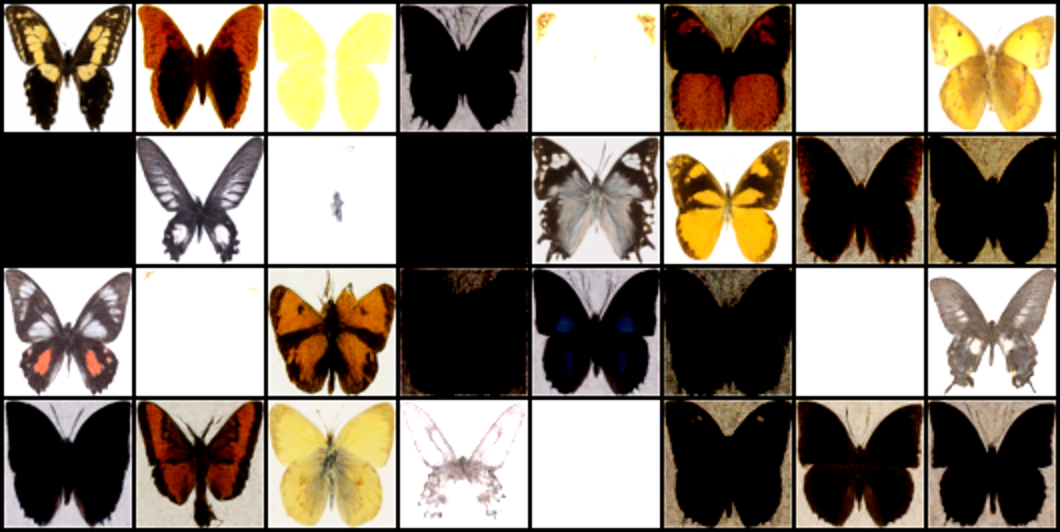

In [ ]:
generate_visualize(denoiser_model, diffusionmodel, (32, TrainingConfig.IMG_SHAPE[0],TrainingConfig.IMG_SHAPE[1],TrainingConfig.IMG_SHAPE[2]), DEVICE)

Now, a problem is that this requires many iterations ($T$, in the order of 100s, 1000s) to produce a high quality sample, without possible paralelization.

"It takes around 20 hours to sample 50k images of size 32 × 32 from a DDPM, but less than a minute to do so from a GAN on a Nvidia 2080 Ti GPU."

## Extensions: Denoising Diffusion Implicit Models (DDIM)

Source: *Denoising Difusion Implicit Models*. Jiaming Song, Chenlin Meng, Stefano Ermon. 2021.


### The idea behind DDIM

In DDPM (what we saw above), the forward/inference process is **Markovian**:

$$
q(\mathbf x_{1:T}|\mathbf x_0)\triangleq \prod_{t=0}^{T-1} q(\mathbf x_{t+1}|\mathbf x_t)
$$

with $q(\mathbf x_{t+1}|\mathbf x_{t})$ having a known (user-designed) Gaussian form.

The **generative process** approximates the reverse process $q(\mathbf x_{t-1}|\mathbf x_{t})$ through $p_\theta(\mathbf x_{t-1}|\mathbf x_{t})$ with $p_\theta(\mathbf x_{0:T})$ also **Markovian**.

Idea:

* In reality, the only "strong" property we use about the diffusion process during DDPM training is $q(\mathbf x_t|\mathbf x_0)$. We do not really use the fact that it is Markovian.
* Hence we could play a bit with $q$ and consider **other forward processes**, with the same **marginal** characteristics $q(\mathbf x_t|\mathbf x_0)$ but with different **joint distribution** $q(\mathbf x_{1:T}|\mathbf x_0)$.
* Consider a family indexed by a sequence $\sigma$ of $\sigma_t$

$$
q_\sigma(\mathbf x_{1:T}|\mathbf x_0) \triangleq q_\sigma(\mathbf x_{T}|\mathbf x_0)\prod_{t=2}^T q_\sigma(\mathbf x_{t-1}|\mathbf x_t,\mathbf x_0),
$$

with $q_\sigma(\mathbf x_{t-1}|\mathbf x_t,\mathbf x_0)=\mathcal N(\sqrt{\bar{\alpha}_{t-1}}\mathbf x_0+\sqrt{1-\bar{\alpha}_{t-1}-\sigma^2_t}\frac{\mathbf x_t - \sqrt{\bar{\alpha}_{t}}\mathbf x_0}{\sqrt{1-\bar{\alpha}_{t}}},\sigma_t^2 \mathbf I)$.

Guess what?



These distributions do satisfy:

$$
q_\sigma(\mathbf x_{t}|\mathbf x_0)=q(\mathbf x_{t}|\mathbf x_0)
$$

from the DDPM.

![](https://miro.medium.com/v2/0*gSM9LfAuZA6f914Y.png)

Imagine that we train our generative process $p_\theta (\mathbf x_{0:T})$ to match $q_{\sigma}$, now, instead of $q$.

Each $p_\theta(\mathbf x_{t-1}|\mathbf x_t)$ now uses the knowledge of $q_\sigma(\mathbf x_{t-1}|\mathbf x_t , \mathbf x_0)$.

What changes: with a noisy observation $\mathbf x_t$, first make a prediction of the corresponding $\mathbf x_0$ (how?), then use it to obtain a sample $\mathbf x_{t-1}$ through the **reverse conditional distribution $q_\sigma (\mathbf x_{t-1} |\mathbf x_t, \mathbf x_0 )$, which we have defined**.

Hence with $\mathbf x_t$ and the estimate of the noise, we can propose an **estimate of the original image $\mathbf x_0$**

$$
f_\theta^{(t)}(\mathbf x_t) \triangleq \frac{1}{\sqrt{\alpha_t}} (\mathbf x_t-\sqrt{1-\alpha_t}\epsilon_\theta(\mathbf x_t,t)).
$$


Now, something great: the authors show that you can use **exactly the same training loss** as DDPM. So, even a trained model under DDPM can be used with that one!


### Sampling from DDIMs

The expression above:

$$
p_\theta^{(t)}(\mathbf x_{t-1}|\mathbf x_t) =
  q_{\sigma}(\mathbf x_{t-1}|\mathbf x_t,f^{(t)}_\theta(\mathbf x_t))
$$

gives us a way to sample $\mathbf x_{t-1}$ from $\mathbf x_t$:

$$
\mathbf x_{t-1} = \sqrt{\bar{\alpha}_{t-1}} \left( \frac{\mathbf x_t - \sqrt{1-\bar{\alpha}_{t}}\epsilon_\theta(\mathbf x_t,t)}{\sqrt{\bar{\alpha}_{t}}}\right)+\sqrt{1-\bar{\alpha}_{t-1}-\sigma^2_t}\epsilon_\theta(\mathbf x_t,t) + \sigma_t \epsilon_t
$$

with $\epsilon_t \sim \mathcal N(0,\mathbf I)$.

Until now, the generative process approximates to the reverse process; since the forward process has $T$ steps, the generative process is also forced to sample $T$ steps.

However, as the denoising objective **does not depend on the specific forward procedure**
as long as $q_\sigma(\mathbf x_t |\mathbf x_0 )$ is the one we should expect, we may also consider **forward processes with lengths smaller than $T$**, which **accelerates the corresponding generative processes without having to train a different model**.

For example, consider a forward process defined on a
**subset** $\{\mathbf x_{\tau_1} , ... , \mathbf x_{\tau_S} \}$, where $\tau$ is an increasing sub-sequence of $[1, . . . , T ]$ of length $S$.

![](https://miro.medium.com/v2/1*Vx4dcClpXX937-Dj0mKDww.png)

The forward distribution should satisfy (again)

$$
q_{\sigma,\tau}(\mathbf x_{\tau_i}|\mathbf x_{0})=\mathcal N(\mathbf x_{\tau_i};\sqrt{\bar{\alpha}_{\tau_i}}\mathbf x_0,(1-\bar{\alpha}_{\tau_i})\mathbf I),
$$


 and a possible choice for the joint distribution is
 $$q_{\sigma,\tau}(\mathbf x_{\tau_{i-1}}|\mathbf x_{\tau_i},\mathbf x_0)=\mathcal N(\sqrt{\bar{\alpha}_{\tau_{i-1}}}\mathbf x_0+\sqrt{1-\bar{\alpha}_{\tau_{i-1}}-\sigma^2_{\tau_{i}}}\frac{\mathbf x_{\tau_{i}} - \sqrt{\bar{\alpha}_{\tau_{i}}}\mathbf x_0}{\sqrt{1-\bar{\alpha}_{\tau_{i}}}},\sigma_{\tau_{i}}^2 \mathbf I).$$

In principle, this means that we can train a model with an arbitrary number of forward steps ($T$) but **only sample from some of them** ($S \ll T$) in the generative process.

Sampling :: 100%|██████████| 25/25 [00:23<00:00,  1.07it/s]


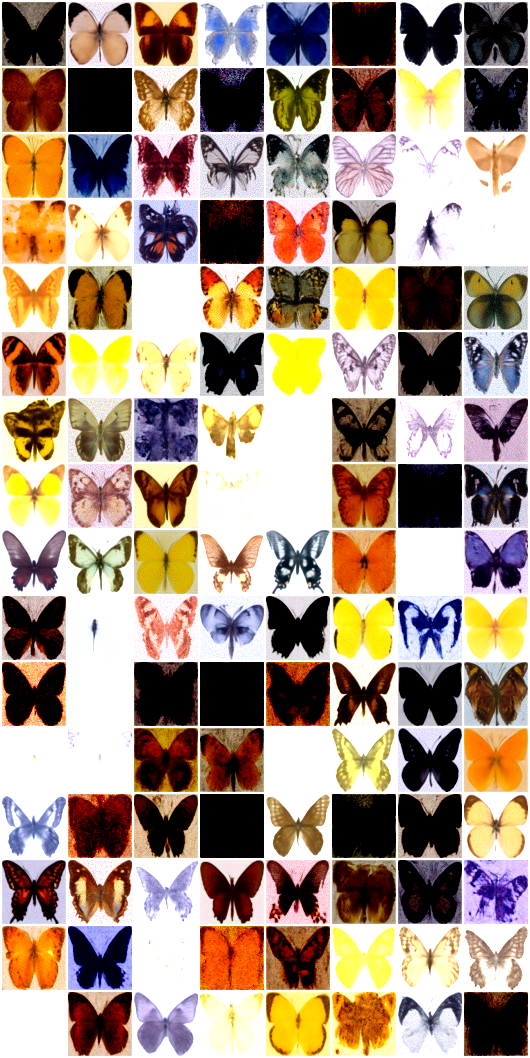

In [ ]:
@torch.inference_mode()
def generate_ddim(denoiser_model:nn.Module,taus,backward_sampler:DDPM,size,device):
    # Noise from a normal distribution
    xnoisy = torch.randn(size, device=device)
    # Set the model in evaluation mode
    denoiser_model.eval()
    last_t                     = torch.ones(size[0], dtype=torch.long, device=device) * (TrainingConfig.TIMESTEPS-1)
    alpha_bar_t                = get_from_idx(backward_sampler.alpha_bar, last_t)
    sqrt_alpha_bar_t           = get_from_idx(backward_sampler.sqrt_alpha_bar, last_t)
    sqrt_one_minus_alpha_bar_t = get_from_idx(backward_sampler.sqrt_one_minus_alpha_bar, last_t)
    # Now, to reverse the diffusion process, use a sequence of denoising steps
    for t in tqdm(iterable=reversed(taus),
                          dynamic_ncols=False,total=len(taus),
                          desc="Sampling :: ", position=0):
        # Time vectors
        ts = torch.ones(size[0], dtype=torch.long, device=device) * t
        # Estimate the noise
        predicted_noise = denoiser_model(xnoisy, ts)
        # The betas, alphas etc.
        alpha_bar_t_prev                = get_from_idx(backward_sampler.alpha_bar, ts)
        sqrt_alpha_bar_t_prev           = get_from_idx(backward_sampler.sqrt_alpha_bar, ts)
        sqrt_one_minus_alpha_bar_t_prev = get_from_idx(backward_sampler.sqrt_one_minus_alpha_bar, ts)
         # Predicted x0
        predicted_x0                    = (xnoisy-sqrt_one_minus_alpha_bar_t*predicted_noise)/sqrt_alpha_bar_t
        # Generating images for t-1 (deterministic way)
        xnoisy = sqrt_alpha_bar_t_prev * predicted_x0 + sqrt_one_minus_alpha_bar_t_prev * predicted_noise
        alpha_bar_t                     = alpha_bar_t_prev
        sqrt_alpha_bar_t                = sqrt_alpha_bar_t_prev
        sqrt_one_minus_alpha_bar_t      = sqrt_one_minus_alpha_bar_t_prev
    return xnoisy

taus = np.arange(0,TrainingConfig.TIMESTEPS,40)
x    = generate_ddim(denoiser_model,taus,diffusionmodel,(128,TrainingConfig.IMG_SHAPE[0],TrainingConfig.IMG_SHAPE[1],TrainingConfig.IMG_SHAPE[2]),DEVICE)
# Display the image at the final timestep of the reverse process.
x    = inverse_transform(x).type(torch.uint8)
grid = torchvision.utils.make_grid(x, nrow=8, pad_value=255.0).to("cpu")
pil_image = TF.functional.to_pil_image(grid)
display(pil_image)

## Extensions: Conditional diffusion

Exactly the same idea but for a **conditional distribution**:

$$
\pi(\mathbf x|\mathbf y)
$$

The only change is that your denoising network will also be conditioned:

$$
\epsilon_\theta(\mathbf x_t,t,\mathbf y).
$$

Example: [conditioning to text, sketch](https://scribblediffusion.com/scribbles/sedmuelbcdupwltrzzl2vqeeam).

## Extensions: Stable diffusion

Ideas:

* Use diffusion in some **latent space** instead of the data space.
* Implies training an auto-encoder apart from the denoiser.
* The generation implies now denoising a noisy realization of the latent variable; then use the decoder to get the finally generated image.

![](https://ommer-lab.com/wp-content/uploads/2022/08/article-Figure3-1-1536x762.png)

## Extensions: Guidance

Ideas:
    
* Each denoising step corresponds to a **displacement in the data space**; you can show that in fact these steps follow temperature-controlled **gradients of the data density**.
* What about adding some components to these displacements with some additional info about where you want your final data end up in the data space?
* Define some potential function $U(\mathbf x)$ reflecting your preferences about the data $\mathbf x$ and add a term

$$
-\alpha \nabla_{\mathbf x} U(\mathbf x),
$$

to the displacements. This is called **guidance**.

Example: use a classifier response as guidance.

![](https://korrawe.github.io/gmd-project/static/images/teaser.jpg)